In [1]:
import kagglehub
from xgboost import XGBRegressor

# Download latest version
path = kagglehub.dataset_download("aslanahmedov/walmart-sales-forecast")

print("Path to dataset files:", path)

/Users/kareemelnaghy/PycharmProjects/MachineLearningTasks/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/kareemelnaghy/.cache/kagglehub/datasets/aslanahmedov/walmart-sales-forecast/versions/1


In [2]:
import pandas as pd
import os

os.listdir(path)

['test.csv', 'train.csv', 'features.csv', 'stores.csv']

In [3]:
# Load datasets
train_df = pd.read_csv(os.path.join(path, "train.csv"))
features_df = pd.read_csv(os.path.join(path, "features.csv"))
stores_df = pd.read_csv(os.path.join(path, "stores.csv"))

In [4]:
# merge datasets to create one comprehensive dataframe
train_merged = pd.merge(train_df, features_df, how='left', on=['Store', 'Date'])
train_merged = pd.merge(train_merged, stores_df, how='left', on='Store')

In [5]:
train_merged.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [6]:
print(train_merged.columns)

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y', 'Type', 'Size'],
      dtype='object')


In [7]:
# Drop duplicate 'IsHoliday' column and convert 'Date' to datetime
train_merged = train_merged.drop('IsHoliday_y', axis=1)
train_merged['Date'] = pd.to_datetime(train_merged['Date'])

In [8]:
train_merged.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [9]:
# create time-based features
train_merged['Month'] = train_merged['Date'].dt.month
train_merged['Year'] = train_merged['Date'].dt.year
train_merged['WeekOfYear'] = train_merged['Date'].dt.isocalendar().week


# Lag Features
for i in range(1,5):
    train_merged[f'Lag{i}_week'] = train_merged['Weekly_Sales'].shift(i)

train_merged[f'Lag52_week'] = train_merged['Weekly_Sales'].shift(52)

# rolling features
train_merged['Rolling_Mean_4'] = train_merged['Weekly_Sales'].shift(1).rolling(window=4).mean()
train_merged['Rolling_Mean_26'] = train_merged['Weekly_Sales'].shift(26).rolling(window=26).mean()
train_merged['Rolling_Mean_52'] = train_merged['Weekly_Sales'].shift(52).rolling(window=52).mean()


In [10]:
train_merged.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Year,WeekOfYear,Lag1_week,Lag2_week,Lag3_week,Lag4_week,Lag52_week,Rolling_Mean_4,Rolling_Mean_26,Rolling_Mean_52
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,...,2010,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,...,2010,6,24924.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,...,2010,7,46039.49,24924.50,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,...,2010,8,41595.55,46039.49,24924.50,NaN,NaN,NaN,NaN,NaN
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,...,2010,9,19403.54,41595.55,46039.49,24924.5,NaN,32990.77,NaN,NaN


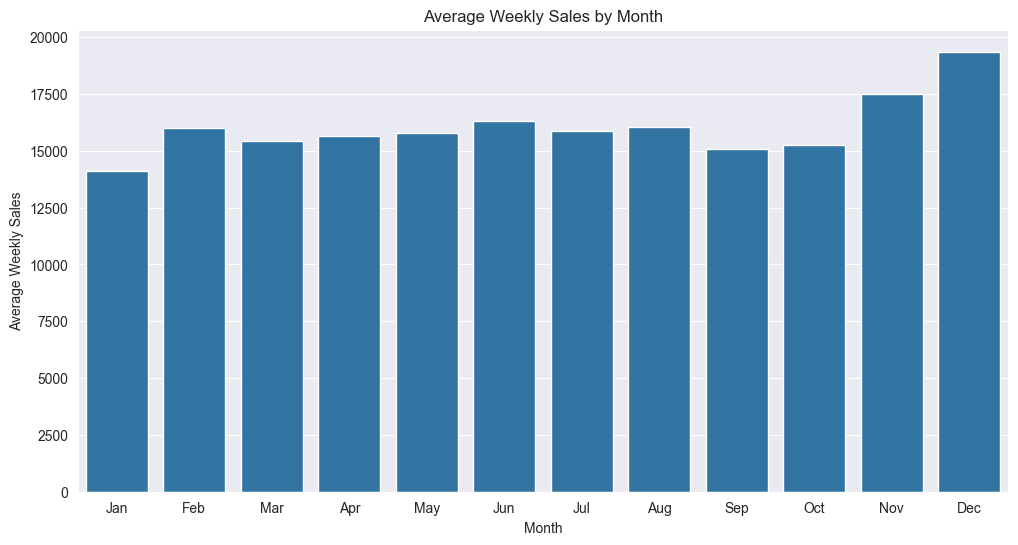

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# average weekly sales by month
plt.figure(figsize=(12, 6))
monthly_sales = train_merged.groupby('Month')['Weekly_Sales'].mean()
sns.barplot(x=monthly_sales.index, y=monthly_sales.values)
plt.title('Average Weekly Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Weekly Sales')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

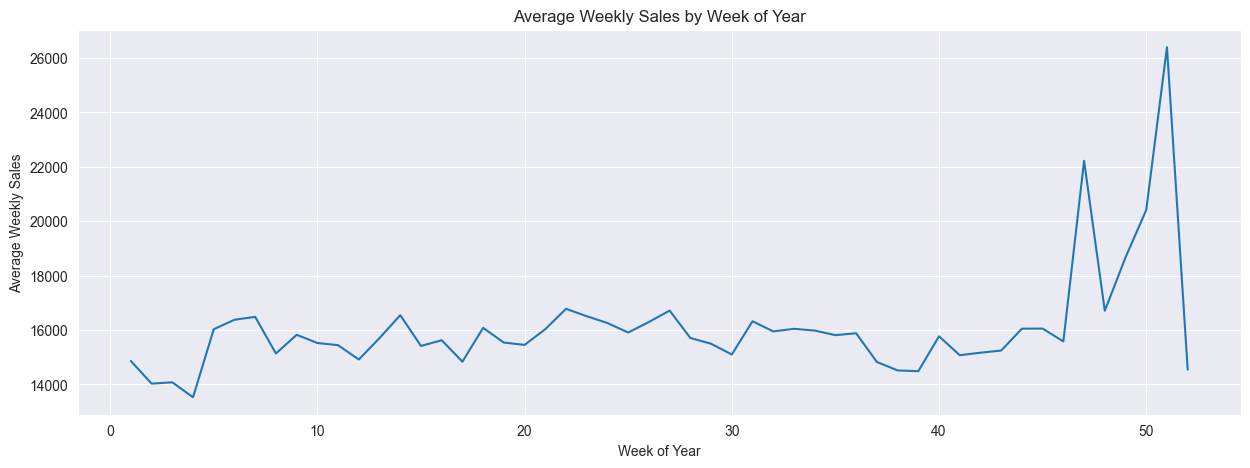

In [12]:
# sales by week of year
plt.figure(figsize=(15, 5))
week_sales = train_merged.groupby('WeekOfYear')['Weekly_Sales'].mean()
sns.lineplot(x=week_sales.index, y=week_sales.values)
plt.title('Average Weekly Sales by Week of Year')
plt.xlabel('Week of Year')
plt.ylabel('Average Weekly Sales')
plt.show()

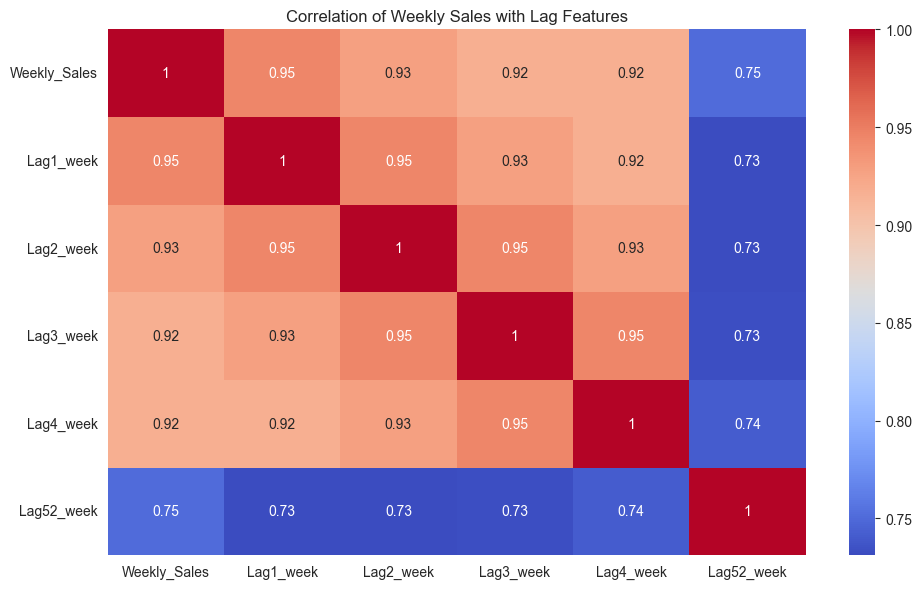

In [13]:
# Lag feature correlation
lag_cols = [col for col in train_merged.columns if 'Lag' in col]
plt.figure(figsize=(10, 6))
sns.heatmap(train_merged[['Weekly_Sales'] + lag_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation of Weekly Sales with Lag Features')
plt.tight_layout()
plt.show()

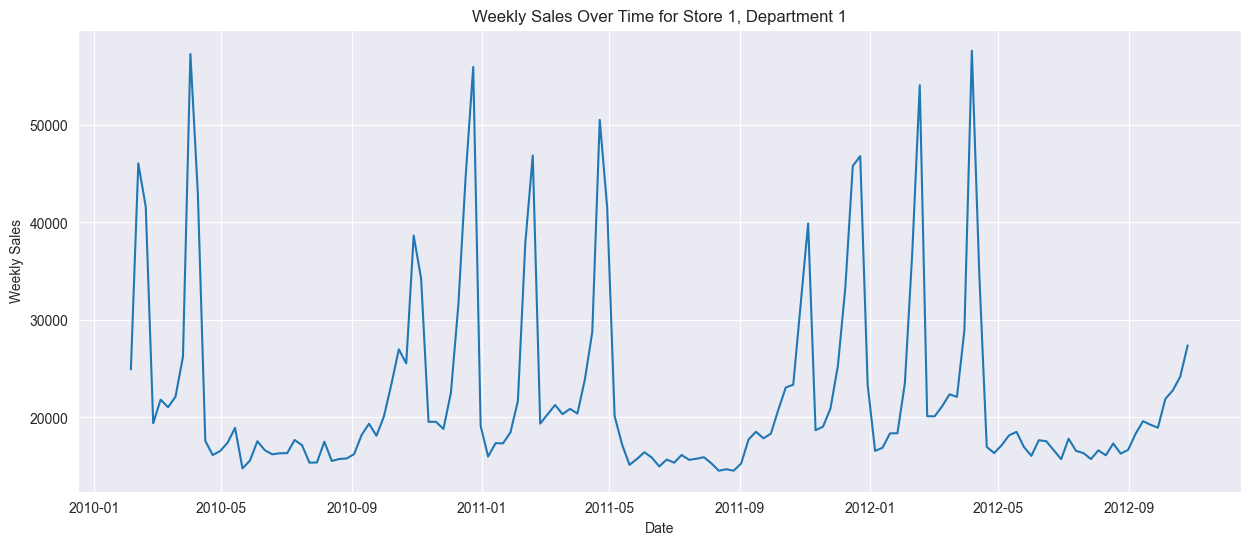

In [14]:
# weekly sales over time for a specific store and department
store_dept = train_merged[(train_merged['Store'] == 1) & (train_merged['Dept'] == 1)].sort_values('Date')
plt.figure(figsize=(15, 6))
plt.plot(store_dept['Date'], store_dept['Weekly_Sales'])
plt.title('Weekly Sales Over Time for Store 1, Department 1')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()

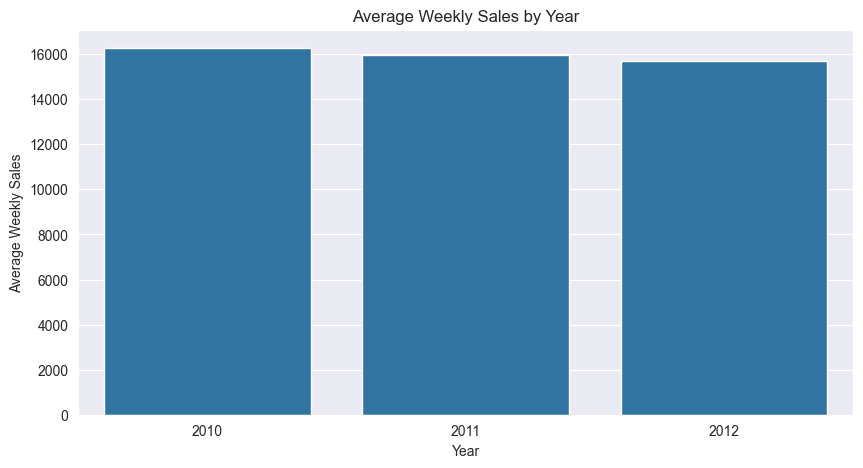

In [15]:
# weekly sales by year
plt.figure(figsize=(10, 5))
year_sales = train_merged.groupby('Year')['Weekly_Sales'].mean()
sns.barplot(x=year_sales.index, y=year_sales.values)
plt.title('Average Weekly Sales by Year')
plt.xlabel('Year')
plt.ylabel('Average Weekly Sales')
plt.show()

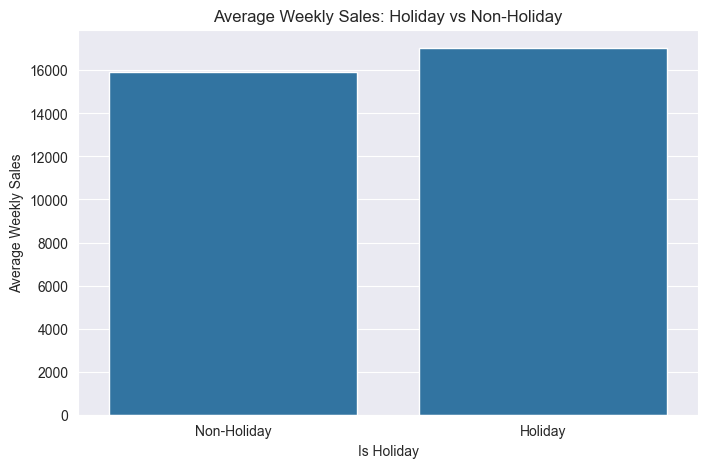

In [16]:
# average weekly sales on holidays vs non-holidays
plt.figure(figsize=(8, 5))
holiday_sales = train_merged.groupby('IsHoliday_x')['Weekly_Sales'].mean()
sns.barplot(x=holiday_sales.index, y=holiday_sales.values)
plt.title('Average Weekly Sales: Holiday vs Non-Holiday')
plt.xlabel('Is Holiday')
plt.ylabel('Average Weekly Sales')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.show()

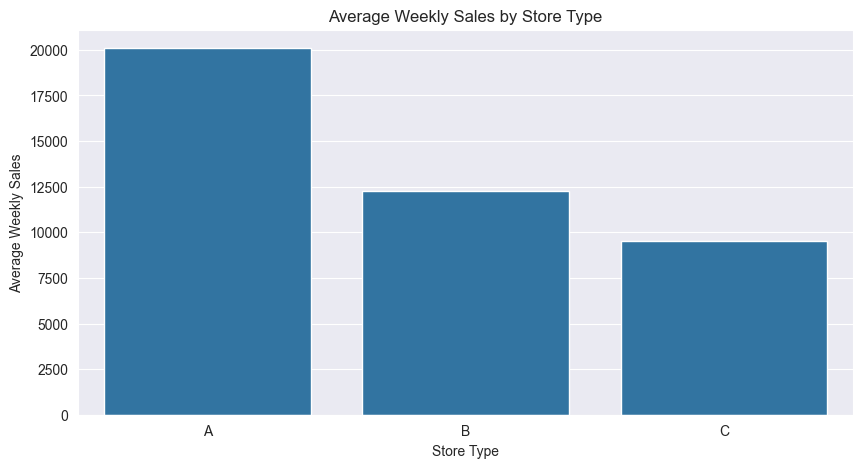

In [17]:
# average weekly sales by store types
plt.figure(figsize=(10, 5))
type_sales = train_merged.groupby('Type')['Weekly_Sales'].mean()
sns.barplot(x=type_sales.index, y=type_sales.values)
plt.title('Average Weekly Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Weekly Sales')
plt.show()

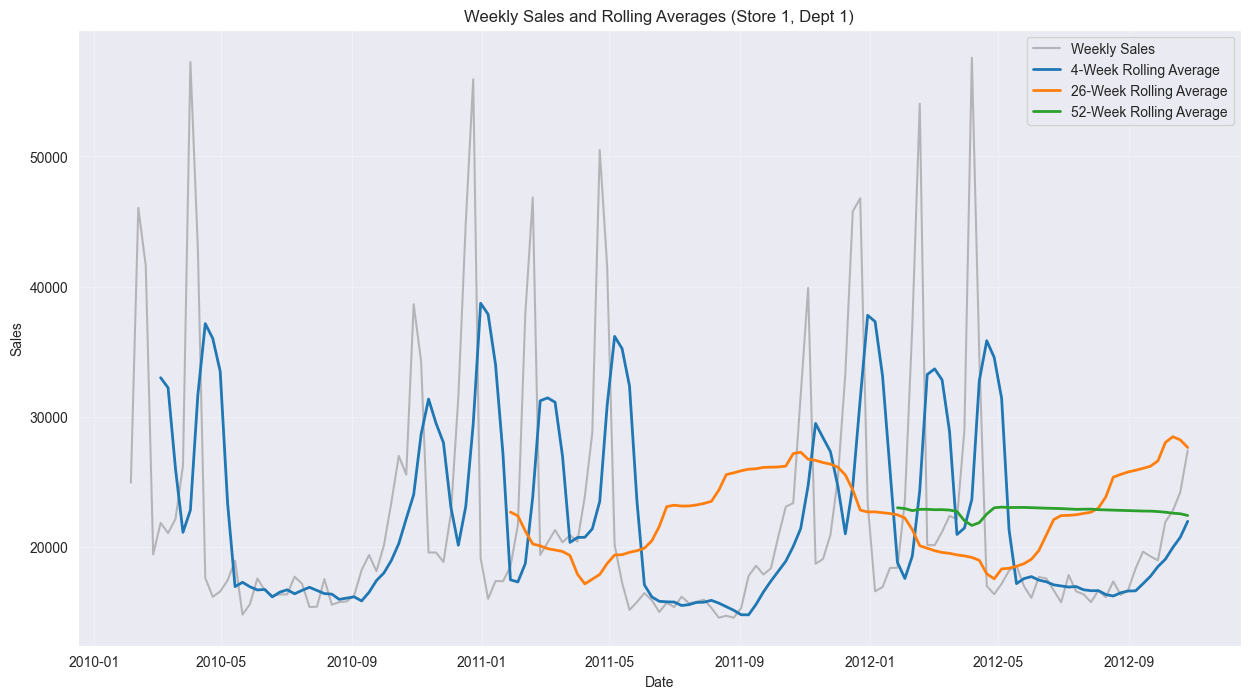

In [18]:
# Select a specific store and department for visualization
store = 1
dept = 1
sample_data = train_merged[(train_merged['Store'] == store) &
                           (train_merged['Dept'] == dept)].sort_values('Date')

# Create visualization
plt.figure(figsize=(15, 8))
plt.plot(sample_data['Date'], sample_data['Weekly_Sales'],
         label='Weekly Sales', color='gray', alpha=0.5)
plt.plot(sample_data['Date'], sample_data['Rolling_Mean_4'],
         label='4-Week Rolling Average', linewidth=2)
plt.plot(sample_data['Date'], sample_data['Rolling_Mean_26'],
         label='26-Week Rolling Average', linewidth=2)
plt.plot(sample_data['Date'], sample_data['Rolling_Mean_52'],
         label='52-Week Rolling Average', linewidth=2)

plt.title(f'Weekly Sales and Rolling Averages (Store {store}, Dept {dept})')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [19]:
# defining features to be used in the model
features = ['Store', 'Dept', 'IsHoliday_x', 'Type', 'Month', 'Year', 'WeekOfYear',
            'Lag1_week', 'Lag2_week', 'Lag3_week', 'Lag4_week', 'Lag52_week',
            'Rolling_Mean_4', 'Rolling_Mean_26', 'Rolling_Mean_52']

In [20]:
# Drop rows with NaN values
train_merged.dropna(inplace=True)

In [21]:
# split data into training and testing sets based on a cutoff date (last 12 weeks is test set)
cutoff_date = train_merged.Date.max() - pd.Timedelta(weeks=12)

train_data = train_merged[train_merged['Date'] <= cutoff_date]
test_data = train_merged[train_merged['Date'] > cutoff_date]

X_train = train_data[features]
y_train = train_data['Weekly_Sales']
X_test = test_data[features]
y_test = test_data['Weekly_Sales']

# Get the complete set of dummy columns from the training data
X_train = pd.get_dummies(train_data[features], drop_first=True)

# Make sure X_test has the same columns as X_train
X_test = pd.get_dummies(test_data[features], drop_first=True)
for col in X_train.columns:
    if col not in X_test.columns:
        X_test[col] = 0

X_test = X_test[X_train.columns]

In [22]:
from xgboost import XGBRegressor
# train the model
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [23]:
# make predictions
predictions = model.predict(X_test)

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# evaluate the model using RMSE, MAE, and R²
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

RMSE: 3025.29
MAE: 1407.87
R²: 0.9829


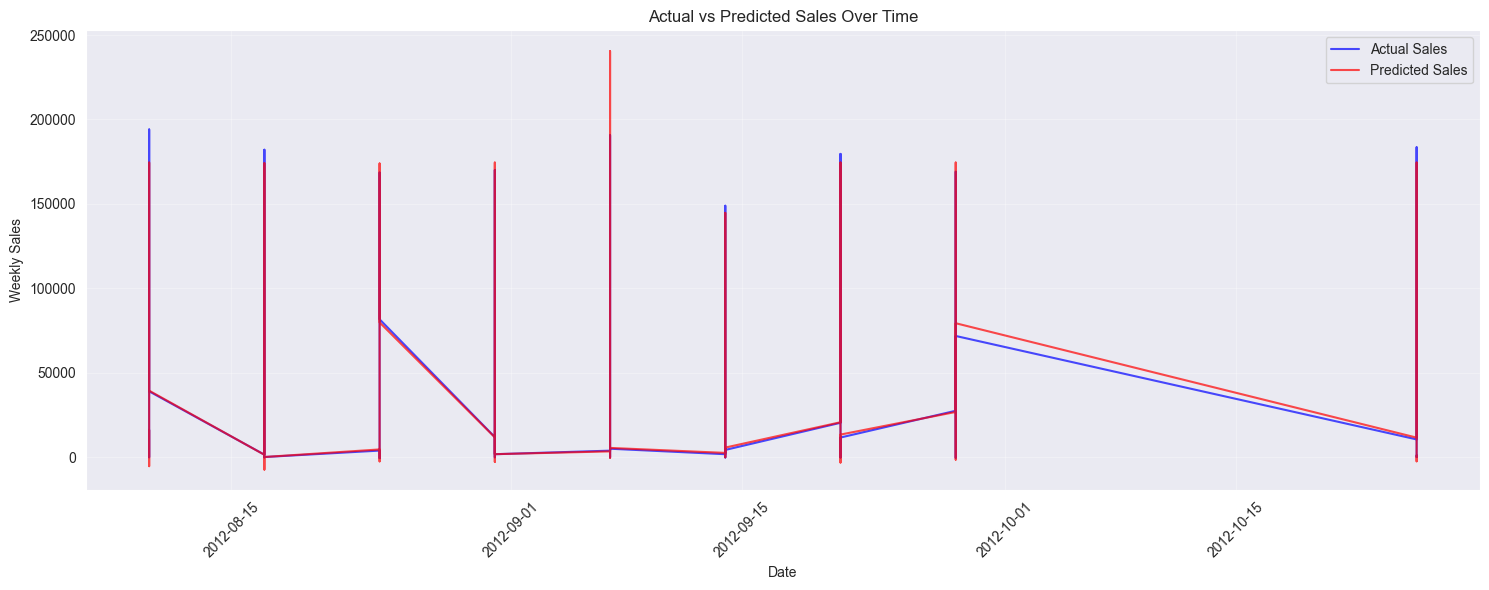

In [25]:
# plot actual vs predicted sales over time
test_df = test_data.copy()
test_df['Predictions'] = predictions

test_df = test_df.sort_values('Date')

plt.figure(figsize=(15, 6))
plt.plot(test_df['Date'], test_df['Weekly_Sales'], label='Actual Sales', color='blue', alpha=0.7)
plt.plot(test_df['Date'], test_df['Predictions'], label='Predicted Sales', color='red', alpha=0.7)
plt.title('Actual vs Predicted Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

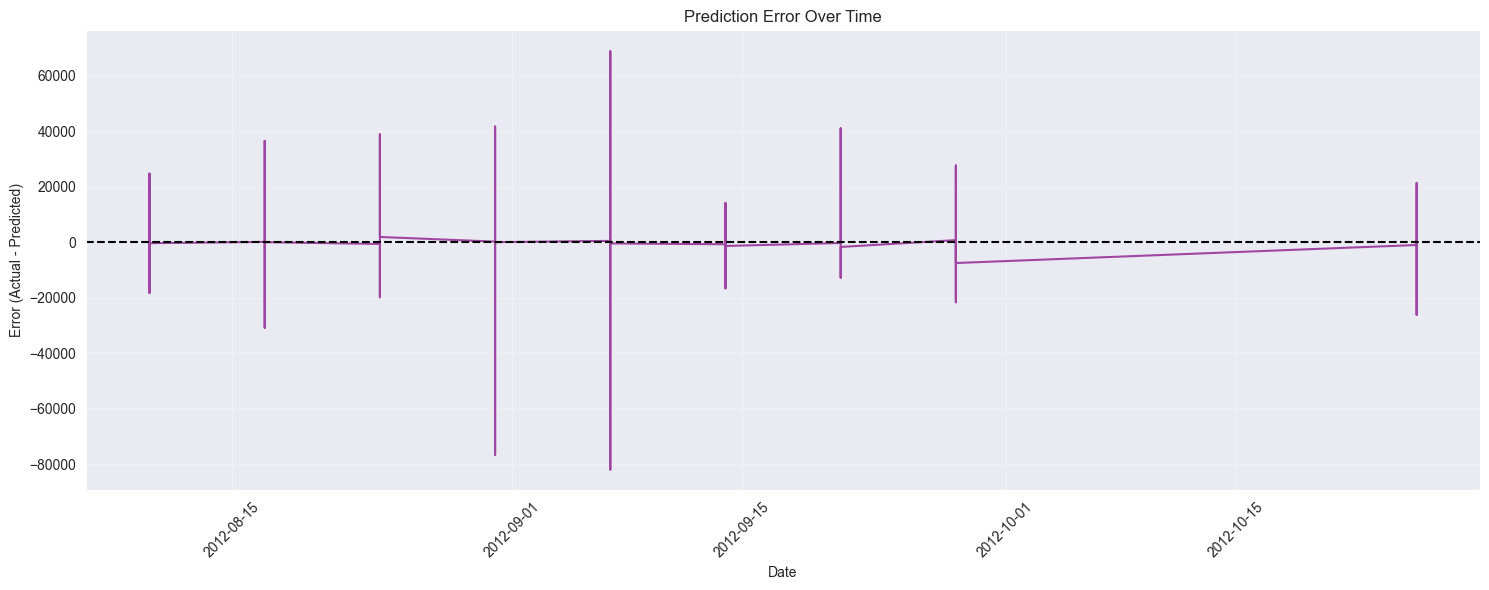

In [26]:
# plot prediction errors over time
test_df['Error'] = test_df['Weekly_Sales'] - test_df['Predictions']
test_df['AbsError'] = abs(test_df['Error'])
test_df['PercentageError'] = (test_df['Error'] / test_df['Weekly_Sales']) * 100

plt.figure(figsize=(15, 6))
plt.plot(test_df['Date'], test_df['Error'], color='purple', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Prediction Error Over Time')
plt.xlabel('Date')
plt.ylabel('Error (Actual - Predicted)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()